In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from astropy import units as u

import pulsar

# Pulsar Profiling

In this project we use computational techniques to simulate and plot a pulsar
profile in which its observed brightness follows the von Mises distribution,
a continuous probability distribution on a circular plane with a range from 0
to 2 $\pi$.

This profile represents a pulsar in a binary system in which its orbiting
companion decreases the observed brightness at regular intervals. The observed 
intensity is defined as:

$$I(\phi \, | \, \mu,\kappa) = I_{peak}e^{\kappa\, cos(\phi-\mu)}$$

Where:

* $\phi$ is the pulsar phase which depends on its angular frequency
* $I_{peak}$ is the peak observed brightness
* $\mu$ is the mean direction of the distribution ($0 \leq \mu \leq 2 \pi$)
* $\kappa$ is the concentration parameter, the reciprocal of dispersion,
defined as:

$$\kappa = \frac{log \, 2}{2\, sin^2(\pi D/2)}$$

When $\kappa = 0$ the distribution is uniform, but for a pulsar its
concentration value depends on $D$, the duty cycle.

References:

* Grafarend, E. & Awange. J. (2012) Applications of Linear and Nonlinear Models:
Fixed Effects, Random Effects. Springer Science & Business Media, Aug 15.
(p. 362)

![Duty Cycles of Pulsars](dutycycle.png)

source https://www.nature.com/articles/2241188a0

## Brightness time series

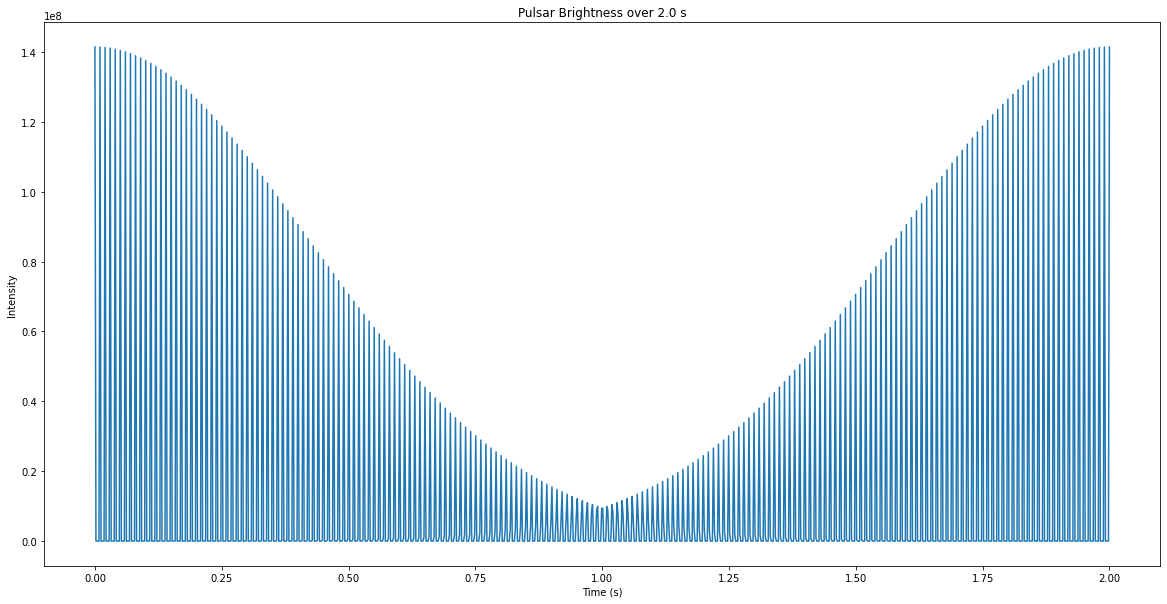

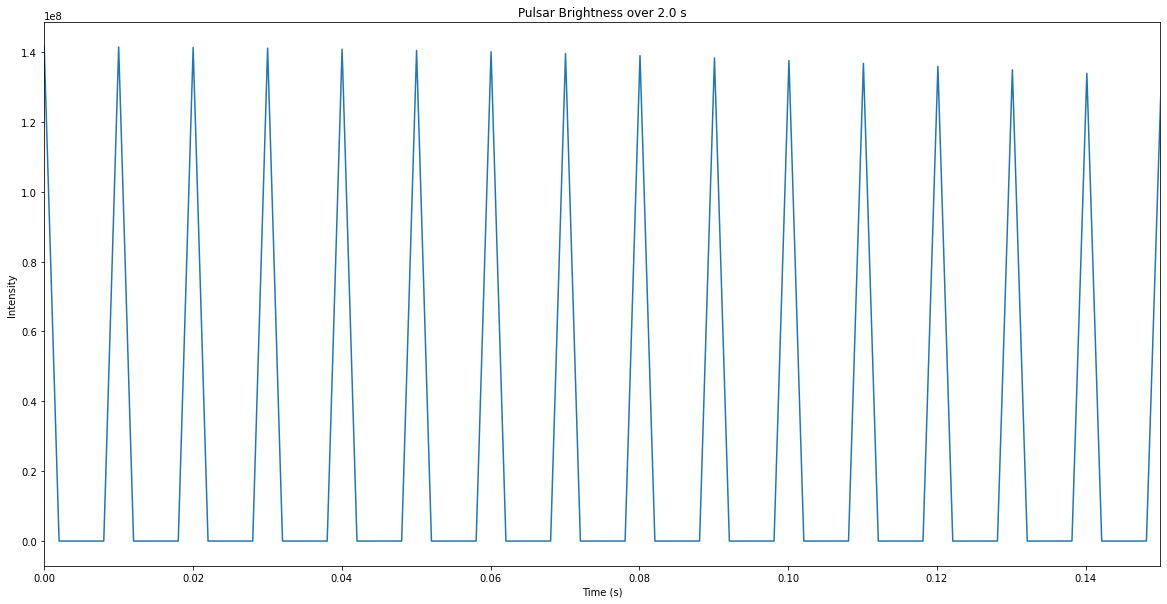

In [6]:
# Global settings for plot size
plt.rcParams["figure.figsize"] = (20, 10)

# Pulsar scenario constants
D = 0.1             # duty cycle number
phi0 = 1 * u.rad    # initial angle value
Ipeak = 100         # amplitude of intensity
period = 0.01 * u.s # rotational period (10 ms)
time = 2 * u.s

def plot_intensity(time: u.s, sample_rate: int, xlim=()):

    tframe = np.linspace(0, time.value, num=sample_rate) * u.s
    intensity = pulsar.linear_intensity(Ipeak, phi0, D, period, tframe)

    plt.plot(tframe, intensity)
    plt.title(f'Pulsar Brightness over {time}')
    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    if len(xlim) == 2:
        plt.xlim(xlim[0], xlim[1])
    plt.show()


plot_intensity(time, 1000)
plot_intensity(time, 1000, (0, 0.15))

## Integrated Brightness

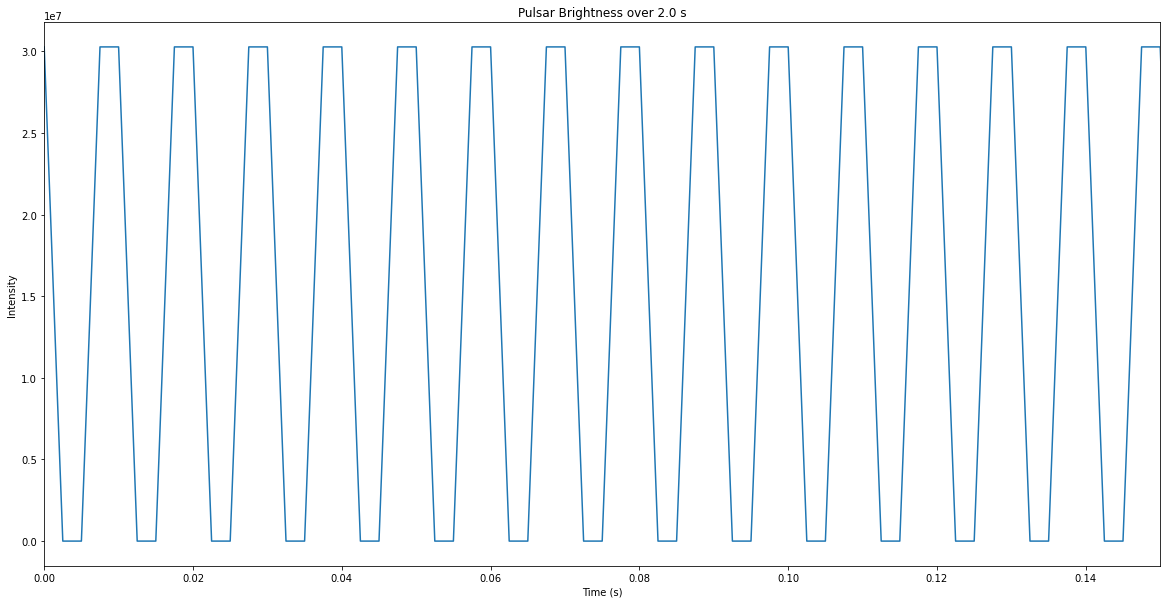

In [7]:
# Integrate the brigthness with a time step of 2.5ms
ts = 0.0025 * u.s # 2.5ms
steps = np.arange(0, time.value, ts.value)

intensity = pulsar.integrated_intensity(Ipeak, phi0, D, period, ts, steps)

plt.plot(steps[:-1], intensity)
plt.title(f'Pulsar Brightness over {time}')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.xlim(0, 0.15)
plt.show()

## Adding noise

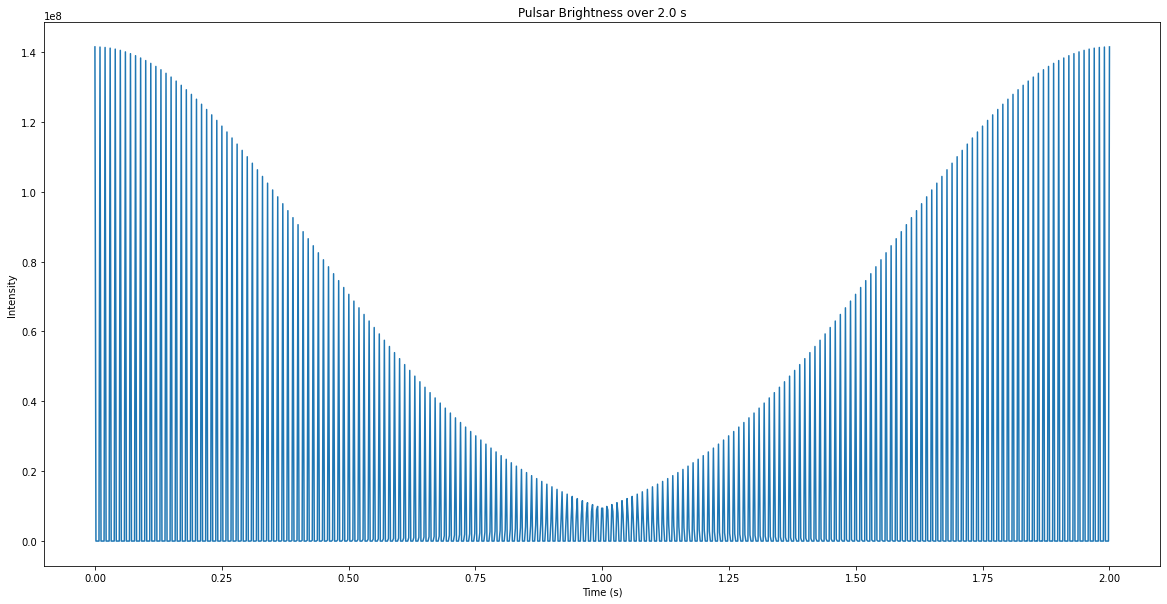

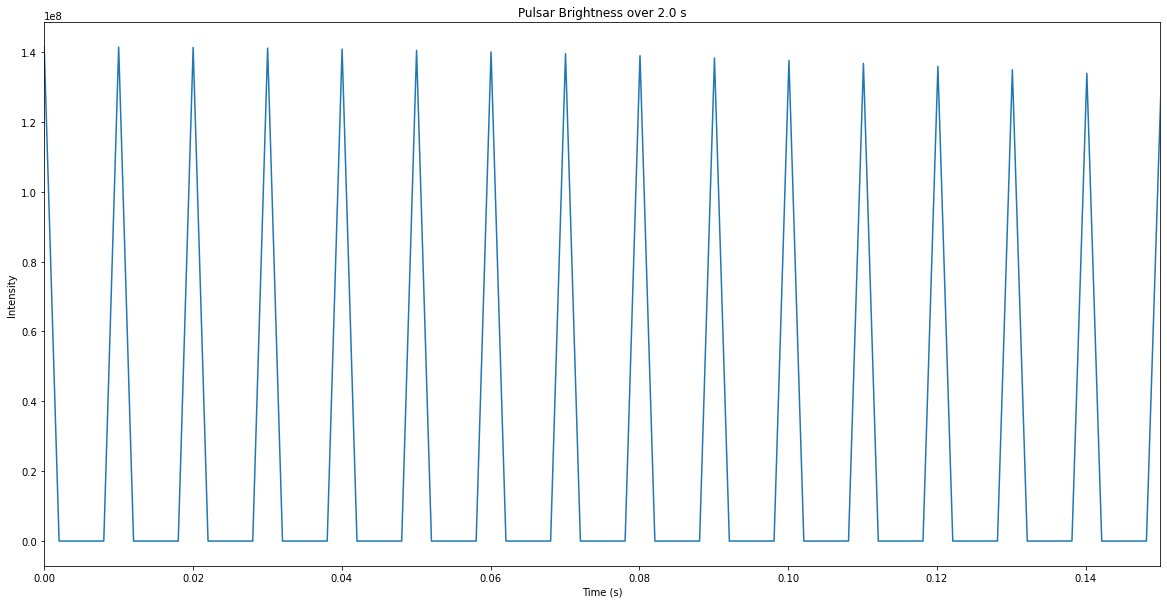

In [9]:
def plot_noisy_intensity(time: u.s, sample_rate: int, xlim=()):

    tframe = np.linspace(0, time.value, sample_rate) * u.s
    signal = pulsar.linear_intensity(Ipeak, phi0, D, period, tframe)

    intensity = pulsar.gaussian_noise(signal, Ipeak*0.2)

    plt.plot(tframe, intensity)
    plt.title(f'Pulsar Brightness over {time}')
    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    if len(xlim) == 2:
        plt.xlim(xlim[0], xlim[1])
    plt.show()

plot_noisy_intensity(time, 1000)
plot_noisy_intensity(time, 1000, (0, 0.15))